In [1]:
from torchvision.datasets import MNIST, FashionMNIST, CIFAR10
import torchvision
import numpy as np
import random

import torch
import torch.nn.functional as F
import cl_gym as cl

import sys
import os

seed = 0

np.random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False
torch.set_num_threads(8)

def make_params() -> dict:
    import os
    from pathlib import Path
    import uuid

    params = {
            # dataset
            'dataset': "BiasedMNIST",
            'fairness_agg': 'mean',
            # 'model': 'MLP',

            # benchmark
            'seed': seed,
            'num_tasks': 5,
            'epochs_per_task': 5,
            'per_task_examples': np.inf,
            # 'per_task_examples': 1000,
            'per_task_memory_examples': 128,
            'batch_size_train': 64,
            'batch_size_memory': 64,
            'batch_size_validation': 256,
            'tau': 10.0,

            # algorithm
            'optimizer': 'sgd',
            'learning_rate': 0.001,
            'momentum': 0.9,
            'learning_rate_decay': 1.0,
            'criterion': torch.nn.CrossEntropyLoss(),
            # 'criterion': torch.nn.BCEWithLogitsLoss(),

            'device': torch.device('cuda:6' if torch.cuda.is_available() else 'cpu'),
             
            # sample selection
            'alpha': 0.01,
            'metric' : "DP",
            'lambda': 1.0,
            'lambda_old': 0.0,
            
            # postprocessing
            "post_processing": "eps_fairness",
            "pp_eps": 0.0,

              }
    

#     trial_id = str(uuid.uuid4())
    trial_id = f"demo/dataset={params['dataset']}/seed={params['seed']}_epoch={params['epochs_per_task']}_lr={params['learning_rate']}_tau={params['tau']}_alpha={params['alpha']}"
    if params['lambda'] != 0:
        trial_id+=f"_lmbd_{params['lambda']}_lmbdold_{params['lambda_old']}"
    params['trial_id'] = trial_id
    params['output_dir'] = os.path.join("./outputs/{}".format(trial_id))
    print(f"output_dir={params['output_dir']}")
    Path(params['output_dir']).mkdir(parents=True, exist_ok=True)

    return params

params = make_params()

output_dir=./outputs/demo/dataset=BiasedMNIST/seed=0_epoch=5_lr=0.001_tau=10.0_alpha=0.01_lmbd_1.0_lmbdold_0.0


In [2]:
"MNIST" in params['dataset']

True

In [3]:
from datasets import BiasedMNIST

if  params['dataset'] in ["BiasedMNIST"]:
    benchmark = BiasedMNIST(num_tasks=params['num_tasks'],
                                per_task_memory_examples=params['per_task_memory_examples'],
                                per_task_examples = params['per_task_examples'],
                                random_class_idx=False)
    input_dim = (3, 28, 28)
    class_idx = benchmark.class_idx
    num_classes = len(class_idx)

[0 1 2 3 4 5 6 7 8 9]


In [4]:
benchmark.mnist_train.sensitives

array([5, 0, 4, ..., 5, 6, 8])

In [5]:
from torchvision.transforms.functional import to_pil_image
from cl_gym.benchmarks.transforms import MNIST_MEAN, MNIST_STD
COLOR_MAP = {
    0: (1, 0, 0),
    1: (0, 1, 0),
    2: (1, 1, 0),
    3: (0, 0, 1),
    4: (1, 0.65, 0),
    5: (0.5, 0, 0.5),
    6: (0, 1, 1),
    7: (1, 0.75, 0.8),
    8: (0.8, 1, 0),
    9: (.588, .294, 0.)
}

r = (1 - 0.1913)
color_values = np.array(list(COLOR_MAP.values()))
m_rgb = color_values.mean(axis=0)
std_rgb = color_values.std(axis=0)

bmnist_mean = [r*m + MNIST_MEAN[0] for m in m_rgb]
bmnist_std = [(r*s**2+(1-r)*MNIST_STD[0]**2+r*(1-r)*(bmnist_mean[i] - m_rgb[i])**2)**0.5 for i, s in enumerate(std_rgb)]

unnormalize = torchvision.transforms.Normalize([-m/s for m, s in zip(bmnist_mean, bmnist_std)], [1/s for s in bmnist_std])
sample_idx = 95
to_pil_image(unnormalize(benchmark.trains[2][sample_idx][0]), mode="RGB")

In [6]:
target_label = 0
incremental_step = 1
# cat_img = torch.cat([img for img in benchmark.trains[incremental_step].inputs[benchmark.trains[incremental_step].targets == target_label][20:30]], dim=2)
cat_img = torch.cat([img for img, target, *_ in benchmark.tests[incremental_step]][20:30], dim=2)
to_pil_image(unnormalize(cat_img), mode="RGB")

In [7]:
from trainers import FairContinualTrainer
from trainers.fair_trainer import FairContinualTrainer2
from metrics import FairMetricCollector
from metrics import MetricCollector2

from algorithms import Heuristic3
from algorithms.fairl import FaIRL
from algorithms.icarl import iCaRL
from backbones import MLP2Layers2

backbone = MLP2Layers2(
    input_dim=input_dim, 
    hidden_dim_1=256, 
    hidden_dim_2=256, 
    output_dim=num_classes,
    class_idx=class_idx,
    config=params
    ).to(params['device'])
# backbone = ResNet18Small2(
#         input_dim=input_dim, 
#         output_dim=num_classes,
#         class_idx=class_idx,
#         config=params
#     ).to(params['device'])
# algorithm = iCaRL(backbone, benchmark, params, requires_memory=True)
algorithm = Heuristic3(backbone, benchmark, params, requires_memory=True)

metric_manager_callback = FairMetricCollector(num_tasks=params['num_tasks'],
                                                        eval_interval='epoch',
                                                        epochs_per_task=params['epochs_per_task'])
# metric_manager_callback = MetricCollector2(num_tasks=params['num_tasks'],
#                                                         eval_interval='epoch',
#                                                         epochs_per_task=params['epochs_per_task'])
from trainers.baselines import BaseMemoryContinualTrainer as ContinualTrainer

# trainer = ContinualTrainer(algorithm, params, callbacks=[metric_manager_callback])

trainer = FairContinualTrainer2(algorithm, params, callbacks=[metric_manager_callback])


In [8]:
algorithm.params['dataset'] == "BiasedMNIST"

True

In [9]:
if params['fairness_agg'] == "mean":
    agg = np.mean
elif params['fairness_agg'] == "max":
    agg = np.max
else:
    raise NotImplementedError

fairness_metrics = ["std", "EER", "EO", "DP"]
for metric in metric_manager_callback.meters:
    if metric in fairness_metrics:
        metric_manager_callback.meters[metric].agg = agg


---------------------------- Task 1 -----------------------
[1] Eval metrics for task 1 >> {'accuracy': 0.8271127393688753, 'loss': 0.0020199846291372964, 'std': 0.04737705654949209, 'EER': -1, 'EO': [0.4595588235294118, 0.25], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.6452205882352942, 'classwise_accuracy': {1: array([ 885, 1135]), 0: array([857, 980])}, 'DP_ingredients': {'class_pred_count_s0': {1: 591, 0: 488}, 'class_pred_count_s1': {1: 576, 0: 459, 2: 1}, 'class_pred_count': {1: 1167, 0: 947, 2: 1}, 'count_s0': 1079, 'count_s1': 1036, 'count': 2115}}
[2] Eval metrics for task 1 >> {'accuracy': 0.907828373640205, 'loss': 0.0011631695725393633, 'std': 0.01972264676795832, 'EER': -1, 'EO': [0.14430894308943087, 0.23345588235294112], 'DP': -1, 'accuracy_s0': 1.0, 'accuracy_s1': 0.811117587278814, 'classwise_accuracy': {0: array([909, 980]), 1: array([1008, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 488, 1: 591}, 'class_pred_count_s1': {1: 536, 0: 494, 4: 6}, 'class_pr

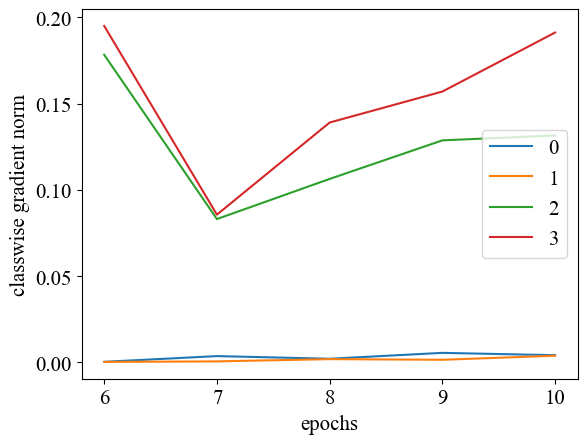

---------------------------- Task 3 -----------------------
losses=tensor([[2.0792e-03, 3.6688e-03, 7.7936e-01, 2.6942e-01, 6.8348e+00, 7.2309e+00,
         5.7466e-02, 7.2565e-02, 1.5855e+00, 1.4509e+00, 7.2790e+00, 7.6344e+00]])
Elapsed time(grad):5.953
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):13.042
Fairness:[0.         0.         0.00230128 0.00417148 0.00041305 0.00404861]
len(updated_seq_indices)=1664
Elapsed time(etc):0.321
[11] Eval metrics for task 1 >> {'accuracy': 0.9647284905151488, 'loss': 0.0007780351008929259, 'std': 0.016769306841679377, 'EER': -1, 'EO': [0.07916833266693324, 0.03507265850502639], 'DP': -1, 'accuracy_s0': 0.9930064353277301, 'accuracy_s1': 0.9358859397417504, 'classwise_accuracy': {0: array([929, 980]), 1: array([1114, 1135])}, 'DP_ingredients': {'class_pred_count_s0': {0: 482, 1: 590, 3: 7}, 'class_pred_count_s1': {0: 484, 1: 524, 2: 4, 3: 21, 4: 3}, 'class_pred_count': {0: 966, 1: 1114, 2: 4, 3: 28, 4: 3}, 'count_s0'

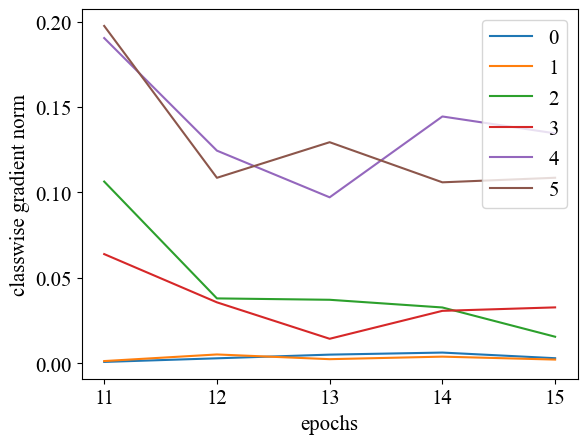

---------------------------- Task 4 -----------------------
losses=tensor([[1.1383e-02, 7.8829e-03, 4.9158e-02, 8.1294e-02, 5.5595e-01, 5.3449e-01,
         8.8556e+00, 6.6028e+00, 1.1821e-01, 5.3684e-02, 1.4452e-01, 2.6792e-01,
         1.0640e+00, 1.6954e+00, 8.8427e+00, 7.8997e+00]])
Elapsed time(grad):5.442
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):19.125
Fairness:[0.         0.00041593 0.0027629  0.00033855 0.0002088  0.00522821
 0.00249142 0.00713744]
len(updated_seq_indices)=1792
Elapsed time(etc):0.331
[16] Eval metrics for task 1 >> {'accuracy': 0.9360649105457161, 'loss': 0.0010518261163229075, 'std': 0.04014654319877731, 'EER': -1, 'EO': [0.04610207026973234, 0.06037584966013598], 'DP': -1, 'accuracy_s0': 0.9622687304096974, 'accuracy_s1': 0.9090297704447632, 'classwise_accuracy': {1: array([1108, 1135]), 0: array([878, 980])}, 'DP_ingredients': {'class_pred_count_s0': {0: 452, 1: 590, 5: 36, 4: 1}, 'class_pred_count_s1': {1: 537, 0: 452, 5:

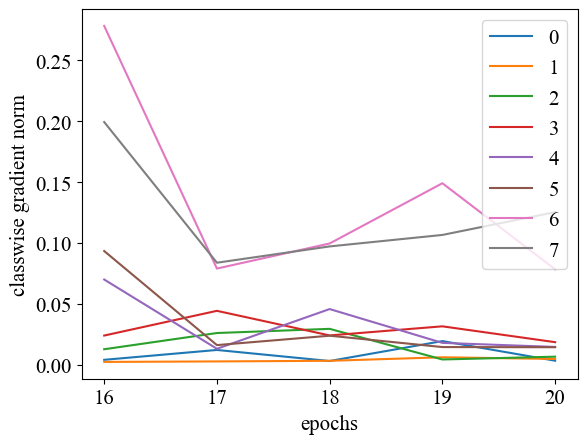

---------------------------- Task 5 -----------------------
losses=tensor([[9.0996e-03, 2.6562e-03, 3.4142e-02, 3.2994e-03, 2.5997e-02, 8.0473e-02,
         8.1069e-01, 5.8579e-01, 8.2201e+00, 9.4792e+00, 9.7221e-02, 8.2165e-02,
         1.0518e-01, 2.0123e-01, 1.8808e-01, 5.0284e-01, 1.5424e+00, 1.6483e+00,
         8.7848e+00, 9.1995e+00]])
Elapsed time(grad):5.478
### Cplex absolute_and_nonabsolute_minsum LP solver ###
Elapsed time(optim):22.204
Fairness:[ 2.16840434e-19 -1.50610528e-04  9.44790683e-04  2.71651894e-03
  4.67930078e-04  2.00910715e-03  0.00000000e+00  1.00543179e-03
  3.58721272e-03  0.00000000e+00]
len(updated_seq_indices)=2240
Elapsed time(etc):0.312
[21] Eval metrics for task 1 >> {'accuracy': 0.8931695585723276, 'loss': 0.0015703749994859628, 'std': 0.012557313674368409, 'EER': -1, 'EO': [0.18963061112769974, 0.21331467413034788], 'DP': -1, 'accuracy_s0': 0.9921604116390669, 'accuracy_s1': 0.7906877690100431, 'classwise_accuracy': {1: array([1028, 1135]), 0: arra

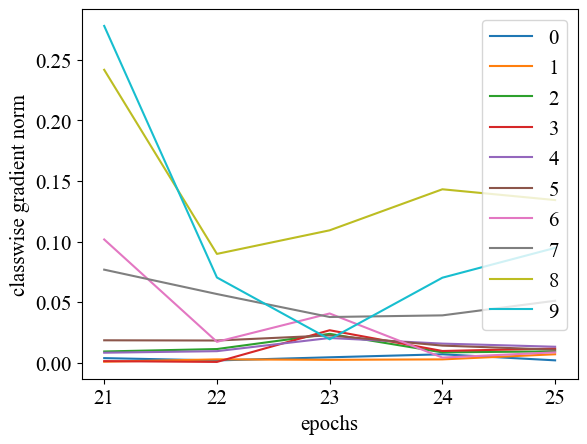

final avg-acc 0.8200440798844302
final avg-forget 0.04931873694152916


In [10]:
trainer.run()
print("final avg-acc", metric_manager_callback.meters['accuracy'].compute_final())
print("final avg-forget", metric_manager_callback.meters['forgetting'].compute_final())

In [11]:
losses, *_ = algorithm.get_loss_grad_all(params['num_tasks']) 
algorithm.true_loss[params['num_tasks']][params['epochs_per_task']] = losses

num_epochs = params['epochs_per_task']
for task in range(2, params['num_tasks']):
    algorithm.true_loss[task][num_epochs] = algorithm.true_loss[task+1][0]


KeyError: 0

In [ ]:
num_class_per_task = 2
t = algorithm.true_loss
e = algorithm.expected_loss
groupwise_true_loss = dict()
groupwise_expected_loss = dict()

for i in range(num_classes):
    groupwise_true_loss[i] = list()
    groupwise_expected_loss[i] = list()
    for j in range(2):
        groupwise_true_loss[i].append(dict())
        groupwise_expected_loss[i].append(dict())


for task in range(2, params['num_tasks']+1):
    for epoch in range(1, num_epochs+1):
        true_loss = np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        excepted_loss = np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1)
        for i, (tl, el) in enumerate(zip(true_loss, excepted_loss)):
            if i < num_class_per_task*task:
                groupwise_true_loss[i][0][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i][0][(task-1)*num_epochs+epoch] = el
            else:
                groupwise_true_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = tl
                groupwise_expected_loss[i-num_class_per_task*task][1][(task-1)*num_epochs+epoch] = el

            
    #     num_class_per_task
    #     print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4).reshape(-1), end="\t")
    #     print()
    # print()


In [ ]:
algorithm.true_loss

{1: {},
 2: {0: tensor([[9.1353e-04, 6.8095e-04, 5.9264e+00, 5.7260e+00, 1.0511e-01, 1.8787e-01,
           6.3502e+00, 6.6903e+00]]),
  1: tensor([[1.7226e-02, 2.1267e-03, 1.2014e+00, 7.8218e-01, 1.7768e-01, 2.3474e-01,
           2.3057e+00, 2.1714e+00]]),
  2: tensor([[0.0094, 0.0083, 1.2242, 1.1632, 0.0664, 0.0882, 2.1711, 2.1352]]),
  3: tensor([[0.0268, 0.0107, 1.2758, 1.5114, 0.1293, 0.0668, 1.7113, 1.5303]]),
  4: tensor([[0.0068, 0.0065, 1.9775, 0.6586, 0.0913, 0.0747, 1.7864, 1.3230]]),
  5: tensor([[9.4947e-03, 6.3977e-03, 2.2454e-01, 8.7626e-01, 6.9395e+00, 6.9210e+00,
           5.6223e-02, 7.5780e-02, 1.7600e+00, 1.6719e+00, 7.3934e+00, 7.7313e+00]])},
 3: {0: tensor([[9.4947e-03, 6.3977e-03, 2.2454e-01, 8.7626e-01, 6.9395e+00, 6.9210e+00,
           5.6223e-02, 7.5780e-02, 1.7600e+00, 1.6719e+00, 7.3934e+00, 7.7313e+00]]),
  1: tensor([[0.0086, 0.0436, 0.1702, 0.1779, 1.4059, 1.0997, 0.0654, 0.2510, 0.5679,
           0.5646, 3.0052, 2.9563]]),
  2: tensor([[0.0238, 0.00

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][0][ce], end='\t')
    print()


0.0172	0.0094	0.0268	0.0068	0.0095	0.0086	0.0238	0.0277	0.0077	0.0076	0.0198	0.0116	0.0315	0.012	0.0134	0.0111	0.0068	0.0088	0.0068	0.0019	
0.0021	0.0083	0.0107	0.0065	0.0064	0.0436	0.0054	0.0156	0.0099	0.0032	0.0197	0.0067	0.0239	0.0167	0.0135	0.07	0.0007	0.0007	0.0047	0.0502	
1.2014	1.2242	1.2758	1.9775	0.2245	0.1702	0.1383	0.0661	0.0697	0.0282	0.0661	0.0885	0.1287	0.0085	0.0399	0.2031	0.1073	0.0355	0.2126	0.0204	
0.7822	1.1632	1.5114	0.6586	0.8763	0.1779	0.0418	0.1596	0.117	0.1393	0.1235	0.085	0.0336	0.0697	0.0274	0.0055	0.0612	0.0093	0.0697	0.0071	
					1.4059	0.7841	1.5706	0.6391	0.7135	0.0885	0.1573	0.0821	0.0358	0.0442	0.0284	0.1681	0.0471	0.0591	0.0428	
					1.0997	1.1503	0.8682	1.1727	0.6376	0.1161	0.1463	0.1181	0.0474	0.0589	0.0715	0.0523	0.1294	0.0324	0.0191	
										0.721	0.4981	1.6339	0.6138	0.2905	0.0375	0.3693	0.0261	0.07	0.0236	
										0.8897	1.3699	1.4533	1.2933	1.6313	0.1671	0.2401	0.1824	0.1481	0.6675	
															0.7959	1.141	0.9807	1.2685	0.4757	
										

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_true_loss[c][1][ce], end='\t')
    print()


0.1777	0.0664	0.1293	0.0913	6.9395	0.0654	0.0435	0.0891	0.0838	8.6515	0.1336	0.1789	0.1068	0.0752	8.5839	0.2031	0.0481	0.0647	0.102	0.0489	
0.2347	0.0882	0.0668	0.0747	6.921	0.251	0.1623	0.1949	0.0306	6.9886	0.1287	0.1289	0.0958	0.0506	9.0534	0.154	0.2099	0.1241	0.2709	0.1014	
2.3057	2.1711	1.7113	1.7864	0.0562	0.5679	0.599	0.2152	0.2318	0.0722	0.1774	0.2271	0.1747	0.0874	0.2843	0.2218	0.2696	0.1518	0.2724	0.1883	
2.1714	2.1352	1.5303	1.323	0.0758	0.5646	0.489	0.3141	0.3401	0.1698	0.3266	0.2063	0.2108	0.2392	0.0443	0.3005	0.2738	0.2633	0.2857	0.3325	
					3.0052	2.0362	1.9099	1.3487	0.1489	0.5235	0.5404	0.3239	0.2335	0.1789	0.3292	0.7517	0.2008	0.4711	0.1236	
					2.9563	2.4935	1.8494	1.9331	0.1576	0.6954	0.5591	0.452	0.4254	0.1155	0.4355	0.6133	0.3097	0.2637	0.2702	
										3.2352	1.4194	1.4801	1.7675	0.3025	0.455	0.3525	0.4339	0.3042	0.1509	
										2.6838	1.8851	1.2798	1.6568	0.367	0.3973	0.823	0.2605	0.2446	0.4061	
															2.6727	2.0716	1.1836	1.7843	1.3173	
												

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][0][ce], end='\t')
    print()


2.0226	2.0322	2.5759	2.0198	2.1182	2.6062	0.8299	1.5792	1.0397	0.7712	0.5502	-0.2653	0.6369	1.1751	0.1821	-1.2677	-0.2851	-0.0345	-0.0399	-0.0328	
-1.0073	1.303	0.9932	1.714	1.6169	0.3277	-0.6521	-0.2522	-0.3478	-0.0397	-1.577	-0.1576	0.1011	0.1871	0.1022	-0.477	0.3897	0.42	0.2011	0.2681	
-0.0395	-0.3252	-0.1711	-0.0466	0.0	1.1218	0.8136	0.8295	1.0793	0.7516	1.7272	0.5824	1.0146	0.6664	0.9599	0.8675	0.6092	0.5901	1.0377	0.6535	
-0.1787	-0.3338	-0.2033	-0.0	-0.0	0.2503	1.4283	1.5035	1.3089	1.596	0.2337	-0.0254	0.0567	0.1779	-0.035	-0.0548	-0.0808	0.3348	0.782	0.1017	
					-0.0	-0.6705	-0.4475	-0.1504	-0.2627	0.3378	1.6429	1.8068	1.3898	1.3622	0.5761	0.5517	0.9329	0.5554	0.8656	
					-0.3189	-0.6836	-0.6023	-0.4309	-0.4172	0.3975	0.8441	0.8971	0.8697	0.8716	0.6101	0.2745	0.816	0.5988	0.6214	
										-0.3745	-0.8296	-0.3	0.0	-0.3642	-0.0645	0.0971	0.9753	0.4765	0.4029	
										-0.486	-0.5043	-0.0131	-0.0	-0.0	1.8343	0.9082	0.9091	1.1418	1.325	
															-0.1324	-0.8269	-0.335	-0.

In [ ]:
for c in range(num_classes):
    for t in range(2, params['num_tasks']+1):
        for e in range(1, num_epochs+1):
            ce = (t-1)*num_epochs+e # current epoch
            if c//num_class_per_task >= t:
                print(f"\t", end='')
                continue
            print(groupwise_expected_loss[c][1][ce], end='\t')
    print()


2.4533	2.2163	2.7096	2.1908	2.0599	2.8036	0.1994	1.2011	0.9784	0.7585	0.5599	0.4021	0.5491	1.0589	0.4497	-1.2898	-0.2901	-0.0351	-0.0519	-0.1838	
-1.0099	1.6233	1.0246	1.77	1.7742	0.1033	-0.3024	0.0276	-0.0491	0.1398	-1.7759	0.3107	0.3273	0.3179	0.1173	-0.4782	-0.1389	-0.0184	0.1455	0.3094	
0.0395	0.3252	0.1711	0.0466	0.0	1.7708	1.2521	0.8012	1.4644	0.8112	2.1021	1.0576	1.0951	0.7136	1.1108	0.9363	0.2815	0.4254	1.0192	0.5849	
0.1787	0.3338	0.2033	-0.0	-0.0	0.2529	1.443	1.734	1.3224	1.6868	0.1163	0.2721	0.253	0.3382	0.3107	0.1216	0.562	0.5434	0.7901	0.5564	
					-0.0	0.6705	0.4475	0.1504	0.2627	0.6807	2.0941	2.131	1.6851	1.4717	0.8734	0.8202	1.3755	0.5368	0.9219	
					0.3189	0.6836	0.6023	0.4309	0.4172	1.3779	1.4925	1.2536	1.1167	1.1923	0.9422	0.5611	1.0015	0.5618	0.372	
										0.3745	0.8296	0.3	-0.0	0.3642	0.601	0.5968	0.963	0.7406	0.731	
										0.486	0.5043	0.0131	0.0	-0.0	1.749	1.3964	1.8452	1.2682	1.3985	
															0.1324	0.8269	0.335	0.0221	0.1393	
															-0.2114

In [ ]:
t = algorithm.true_loss
e = algorithm.expected_loss
num_epochs = params['epochs_per_task']
for task in range(2, params['num_tasks']):
    algorithm.true_loss[task][num_epochs] = algorithm.true_loss[task+1][0]
# algorithm.true_loss[5][num_epochs] = algorithm.true_loss[5][num_epochs-1]

for task in range(2, params['num_tasks']+1):
    print(f"{task=}")
    for epoch in range(1, num_epochs+1):
        print(np.round(t[task][epoch].cpu().detach().numpy().astype("float64"), 4), end="\t")
        print(np.round(e[task][epoch].cpu().detach().numpy().astype("float64"), 4), end="\t")
        print()
    print()



task=2
[[1.7200e-02 2.1000e-03 1.2014e+00 7.8220e-01 1.7770e-01 2.3470e-01
  2.3057e+00 2.1714e+00]]	[[ 2.0226 -1.0073 -0.0395 -0.1787  2.4533 -1.0099  0.0395  0.1787]]	
[[0.0094 0.0083 1.2242 1.1632 0.0664 0.0882 2.1711 2.1352]]	[[ 2.0322  1.303  -0.3252 -0.3338  2.2163  1.6233  0.3252  0.3338]]	
[[0.0268 0.0107 1.2758 1.5114 0.1293 0.0668 1.7113 1.5303]]	[[ 2.5759  0.9932 -0.1711 -0.2033  2.7096  1.0246  0.1711  0.2033]]	
[[0.0068 0.0065 1.9775 0.6586 0.0913 0.0747 1.7864 1.323 ]]	[[ 2.0198  1.714  -0.0466 -0.      2.1908  1.77    0.0466 -0.    ]]	
[[9.5000e-03 6.4000e-03 2.2450e-01 8.7630e-01 6.9395e+00 6.9210e+00
  5.6200e-02 7.5800e-02 1.7600e+00 1.6719e+00 7.3934e+00 7.7313e+00]]	[[ 2.1182  1.6169  0.     -0.      2.0599  1.7742  0.     -0.    ]]	

task=3
[[0.0086 0.0436 0.1702 0.1779 1.4059 1.0997 0.0654 0.251  0.5679 0.5646
  3.0052 2.9563]]	[[ 2.6062  0.3277  1.1218  0.2503 -0.     -0.3189  2.8036  0.1033  1.7708
   0.2529 -0.      0.3189]]	
[[0.0238 0.0054 0.1383 0.0418 0.784

In [ ]:
import copy
task_weight = copy.deepcopy(algorithm.weight_all)

num_bin = 20
np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin)

def bin(w: np.array, num_bin=20):
    out = dict()
    for r in np.arange(0+1/num_bin, 1+1/num_bin, 1/num_bin):
        r = np.round(r, 2)
        out[r] = np.sum(np.logical_and(w<=r, r-1/num_bin<w))
    out[1/num_bin] += np.sum(w==0)
    kk = list(out.keys())
    for k in kk:
        if out[k] == 0:
            del(out[k])
    return out


binned_weight = dict()
for i, wt in enumerate(task_weight):
    if i==0:
        continue
    print(f"task:{i+1}")
    binned_weight[i+1] = list()
    for we in wt:
        binned_weight[i+1].append({k: bin(we[k]) for k in we})




task:2
task:3
task:4
task:5


In [ ]:
binned_weight

{2: [{0: {0.05: 209, 0.7: 1, 1.0: 740}, 1: {1.0: 50}},
  {0: {0.05: 426, 0.8: 1, 0.95: 1, 1.0: 522}, 1: {1.0: 50}},
  {0: {0.05: 499, 0.4: 1, 0.6: 1, 1.0: 449}, 1: {0.05: 1, 1.0: 49}},
  {0: {0.05: 440, 0.15: 1, 1.0: 509}, 1: {1.0: 50}},
  {0: {0.05: 438, 0.4: 1, 0.55: 1, 1.0: 510}, 1: {1.0: 50}}],
 3: [{0: {1.0: 955}, 1: {1.0: 45}},
  {0: {0.05: 396, 0.2: 1, 0.4: 1, 0.5: 1, 1.0: 556}, 1: {0.05: 3, 1.0: 42}},
  {0: {0.05: 400, 0.75: 1, 1.0: 554}, 1: {0.05: 4, 1.0: 41}},
  {0: {0.05: 417, 0.6: 1, 1.0: 537}, 1: {0.05: 5, 1.0: 40}},
  {0: {0.05: 448, 0.4: 1, 0.8: 1, 1.0: 505}, 1: {0.05: 3, 1.0: 42}}],
 4: [{0: {1.0: 950}, 1: {1.0: 50}},
  {0: {0.05: 368, 0.55: 1, 0.65: 1, 1.0: 580}, 1: {1.0: 50}},
  {0: {0.05: 294, 0.15: 1, 0.6: 1, 1.0: 654}, 1: {1.0: 50}},
  {0: {0.05: 341, 0.8: 1, 0.95: 1, 1.0: 607}, 1: {1.0: 50}},
  {0: {0.05: 372, 0.5: 1, 0.6: 1, 1.0: 576}, 1: {1.0: 50}}],
 5: [{0: {1.0: 955}, 1: {1.0: 45}},
  {0: {0.05: 527, 0.45: 1, 1.0: 427}, 1: {0.05: 1, 1.0: 44}},
  {0: {0.05: 44

In [ ]:
metric_manager_callback.meters['accuracy'].get_data()

array([[0.79 , 0.   , 0.   , 0.   , 0.   ],
       [0.972, 0.489, 0.   , 0.   , 0.   ],
       [0.962, 0.877, 0.471, 0.   , 0.   ],
       [0.957, 0.832, 0.806, 0.481, 0.   ],
       [0.931, 0.856, 0.764, 0.856, 0.504]])

In [ ]:
np.mean(metric_manager_callback.meters['accuracy'].compute_overall())

0.7684549914058477

In [ ]:
[np.round(x, 3) for x in metric_manager_callback.meters['EO'].compute_overall()]

[0.423, 0.427, 0.388, 0.395, 0.351]

In [ ]:
np.mean(metric_manager_callback.meters['EO'].compute_overall())

0.39687927671185647

In [ ]:
[np.round(x, 3) for x in metric_manager_callback.meters['DP'].compute_overall()]

[0.115, 0.062, 0.042, 0.02, 0.014]

In [ ]:
np.mean(metric_manager_callback.meters['DP'].compute_overall())

0.05044606516966345

In [ ]:
task_id = 2

print(f"{task_id=}")
print(f"sensitive samples / all samples = {(benchmark.trains[task_id].sensitives != benchmark.trains[task_id].targets).sum().item()} / {benchmark.trains[task_id].sensitives.shape[0]}")

updated_seq_indices = benchmark.seq_indices_train[task_id]
print(f"sensitive samples / selected samples = {(benchmark.trains[task_id].sensitives[updated_seq_indices] != benchmark.trains[task_id].targets[updated_seq_indices]).sum().item()} / {len(updated_seq_indices)}")


task_id=2
sensitive samples / all samples = 568 / 12089
sensitive samples / selected samples = 50 / 1000


In [ ]:
step_class = 2
for i in range(2, 6):
    incremental_step = i
    print(f"{incremental_step=}")
    one_idx = benchmark.trains[incremental_step].sample_weight > 0.9

    print(f"{2*i-2} : {(benchmark.trains[incremental_step].targets == (2*i-2)).sum().item()} --> {(benchmark.trains[incremental_step].targets[one_idx] == (2*i-2)).sum().item()}")
    print(f"{2*i-1} : {(benchmark.trains[incremental_step].targets == (2*i-1)).sum().item()} --> {(benchmark.trains[incremental_step].targets[one_idx] == (2*i-1)).sum().item()}")


incremental_step=2
2 : 5958 --> 5738
3 : 6131 --> 5911
incremental_step=3
4 : 5842 --> 5605
5 : 5421 --> 5205
incremental_step=4
6 : 5918 --> 5724
7 : 6265 --> 6085
incremental_step=5
8 : 5851 --> 5635
9 : 5949 --> 5688


In [ ]:
metric_manager_callback.meters['classwise_accuracy'].get_data()

[{0: array([401, 452]), 1: array([380, 548])},
 {1: array([543, 548]),
  0: array([431, 452]),
  3: array([200, 500]),
  2: array([289, 500])},
 {0: array([425, 452]),
  1: array([539, 548]),
  2: array([416, 500]),
  3: array([461, 500]),
  4: array([260, 531]),
  5: array([212, 469])},
 {0: array([425, 452]),
  1: array([534, 548]),
  3: array([401, 500]),
  2: array([431, 500]),
  4: array([443, 531]),
  5: array([365, 469]),
  6: array([244, 466]),
  7: array([234, 534])},
 {1: array([516, 548]),
  0: array([416, 452]),
  2: array([416, 500]),
  3: array([440, 500]),
  5: array([331, 469]),
  4: array([437, 531]),
  6: array([400, 466]),
  7: array([456, 534]),
  9: array([239, 502]),
  8: array([265, 498])}]